# Loading the libraries

In [58]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import seaborn as sns
import scipy.cluster.hierarchy as sch
import sklearn.utils

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from yellowbrick.cluster import KElbowVisualizer



%matplotlib inline
sns.set_style('whitegrid')

# Loading the data

In [59]:
input_data = pd.read_csv("Wholesale customers data.csv", sep=",")

In [60]:
# Find the dimensionality of the Data
print(input_data.shape)

(440, 8)


In [61]:
#Display the first few rows using head()
input_data.head(10)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


In [62]:
# Set the index to "Channel"

input_data.set_index('Channel', inplace=True)

In [63]:
input_data.head(10)

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,,,,,,,
2,3,12669,9656,7561,214,2674,1338
2,3,7057,9810,9568,1762,3293,1776
2,3,6353,8808,7684,2405,3516,7844
1,3,13265,1196,4221,6404,507,1788
2,3,22615,5410,7198,3915,1777,5185
2,3,9413,8259,5126,666,1795,1451
2,3,12126,3199,6975,480,3140,545
2,3,7579,4956,9426,1669,3321,2566
1,3,5963,3648,6192,425,1716,750


In [64]:
# Create a feature for total customer size

input_data['Total'] = input_data['Fresh'] + input_data['Milk'] + input_data['Grocery'] + input_data['Frozen'] + input_data['Detergents_Paper'] + input_data['Delicassen']
input_data.head()

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total
Channel,,,,,,,,
2,3,12669,9656,7561,214,2674,1338,34112
2,3,7057,9810,9568,1762,3293,1776,33266
2,3,6353,8808,7684,2405,3516,7844,36610
1,3,13265,1196,4221,6404,507,1788,27381
2,3,22615,5410,7198,3915,1777,5185,46100


# Exploratory Data Analysis (EDA)# Exploratory Data Analysis (EDA)

In [ ]:
# Add a function to convert and join dummy variables to the model

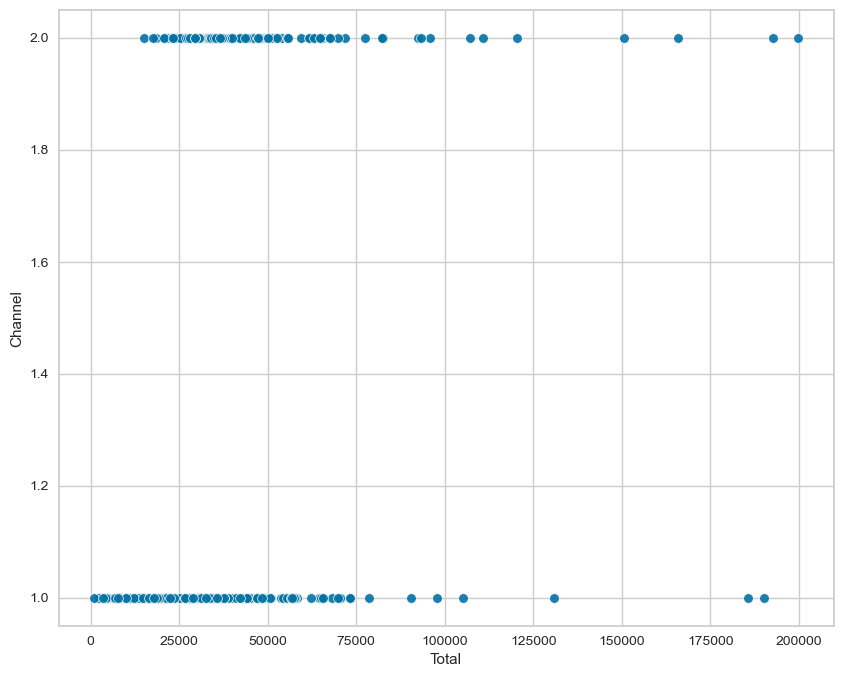

In [84]:
# Plot the features "Channel" and "Fresh" in a scatterplot against each other
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Total', y='Channel', data=input_data, alpha=0.9)
plt.show();

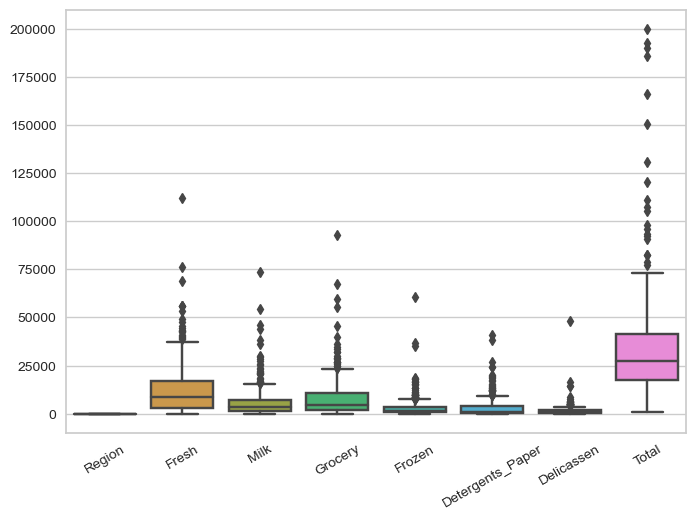

In [66]:
# Use a boxplot to check for any differences in feature ranges (scales)

ax = sns.boxplot(data=input_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show();

# Data pre-processing

Scaling - Since the clusturing algos use distance as a metric to create categories, we need to scale the data

In [67]:
# Instantiate the StandardScaler and fit_transform the input_data. 
# Save the results in a new variable named X_scaled 

scaler   = StandardScaler()
X_scaled = scaler.fit_transform(input_data)

In [68]:
pd.DataFrame(X_scaled).describe()

,0,1,2,3,4,5,6,7
count,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02
mean,-5.737834e-16,-2.422305e-17,-1.589638e-17,-6.030530e-17,1.135455e-17,-1.917658e-17,-8.276208e-17,9.386431e-17
std,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00
min,-1.995342e+00,-9.496831e-01,-7.787951e-01,-8.373344e-01,-6.283430e-01,-6.044165e-01,-5.402644e-01,-1.227749e+00
25%,-7.023369e-01,-7.023339e-01,-5.783063e-01,-6.108364e-01,-4.804306e-01,-5.511349e-01,-3.964005e-01,-5.993005e-01
50%,5.906683e-01,-2.767602e-01,-2.942580e-01,-3.366684e-01,-3.188045e-01,-4.336004e-01,-1.985766e-01,-2.178099e-01
75%,5.906683e-01,3.905226e-01,1.890921e-01,2.849105e-01,9.946441e-02,2.184822e-01,1.048598e-01,3.069688e-01
max,5.906683e-01,7.927738e+00,9.183650e+00,8.936528e+00,1.191900e+01,7.967672e+00,1.647845e+01,6.330728e+00


# K-means clustering 

In [69]:
# Instantiate a KMeans object with a n_clusters = 2
# Store it in a variable named "km" 
# Fit the km model on the X_scaled data and use the predict() function (or directly fit_predict()) 
# to get the assinged clusters. Save the results in a new variable "cluster_assignment"

km = KMeans(n_clusters = 2)
cluster_assignment = km.fit_predict(X_scaled)
cluster_assignment

C:\Users\dchatzopoulou\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [70]:
# Store the results of cluster_assignment to input_data["KMCluster"]
# Use head() once more on input_data

input_data["KMCluster"] = cluster_assignment
input_data.head(10)

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total,KMCluster
Channel,,,,,,,,,
2,3,12669,9656,7561,214,2674,1338,34112,0
2,3,7057,9810,9568,1762,3293,1776,33266,0
2,3,6353,8808,7684,2405,3516,7844,36610,0
1,3,13265,1196,4221,6404,507,1788,27381,0
2,3,22615,5410,7198,3915,1777,5185,46100,0
2,3,9413,8259,5126,666,1795,1451,26710,0
2,3,12126,3199,6975,480,3140,545,26465,0
2,3,7579,4956,9426,1669,3321,2566,29517,0
1,3,5963,3648,6192,425,1716,750,18694,0


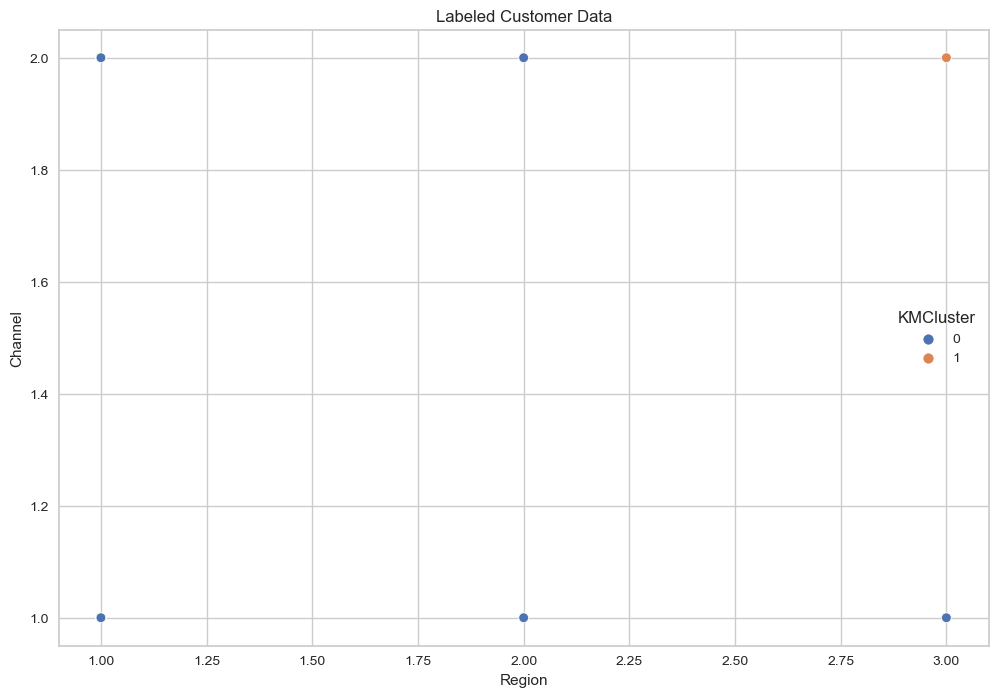

In [71]:
# Visualize the clusters using a scatterplot of the two features against each other and set the hue as the "KMCluster"

plt.figure(figsize=(12,8))

sns.scatterplot(x='Region', 
                y='Channel', 
                data=input_data, 
                hue= "KMCluster",
                palette="deep"
               ).set_title('Labeled Customer Data')

plt.show()

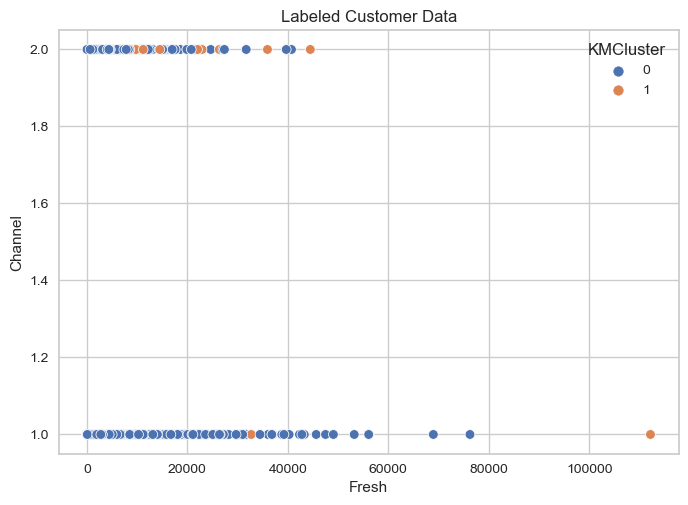

In [72]:
sns.scatterplot(x='Fresh', 
                y='Channel', 
                data=input_data, 
                hue= "KMCluster",
                palette="deep"
               ).set_title('Labeled Customer Data')

plt.show()

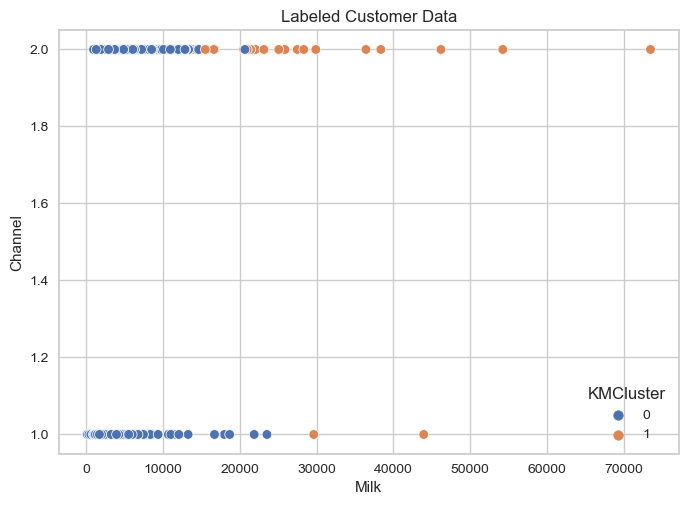

In [73]:
sns.scatterplot(x='Milk', 
                y='Channel', 
                data=input_data, 
                hue= "KMCluster",
                palette="deep"
               ).set_title('Labeled Customer Data')

plt.show()

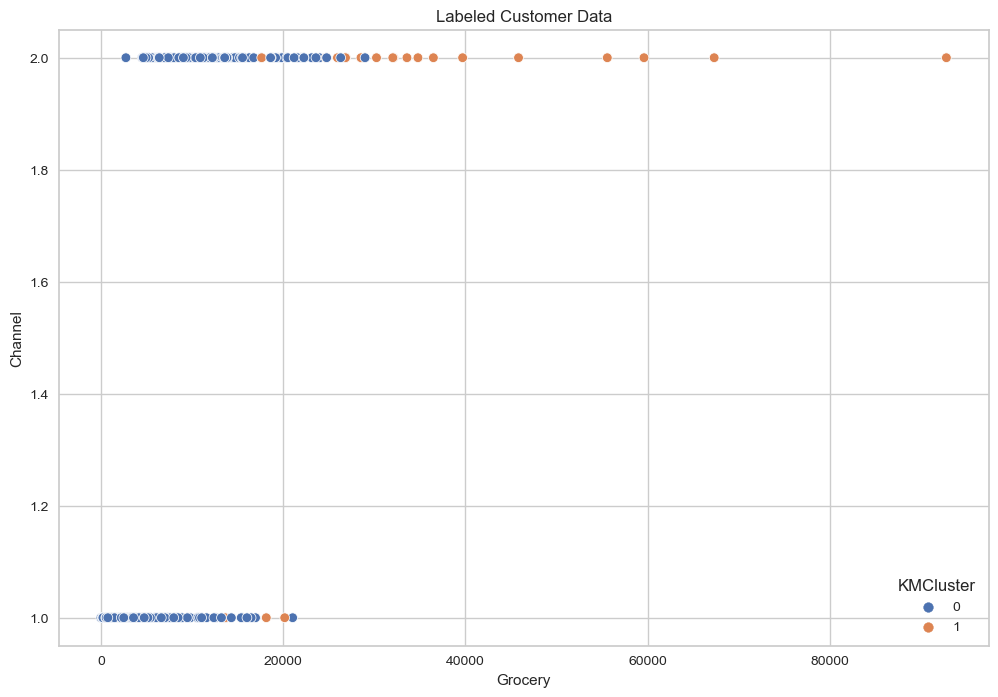

In [74]:
plt.figure(figsize=(12,8))

sns.scatterplot(x='Grocery', 
                y='Channel', 
                data=input_data, 
                hue= "KMCluster",
                palette="deep"
               ).set_title('Labeled Customer Data')

plt.show()

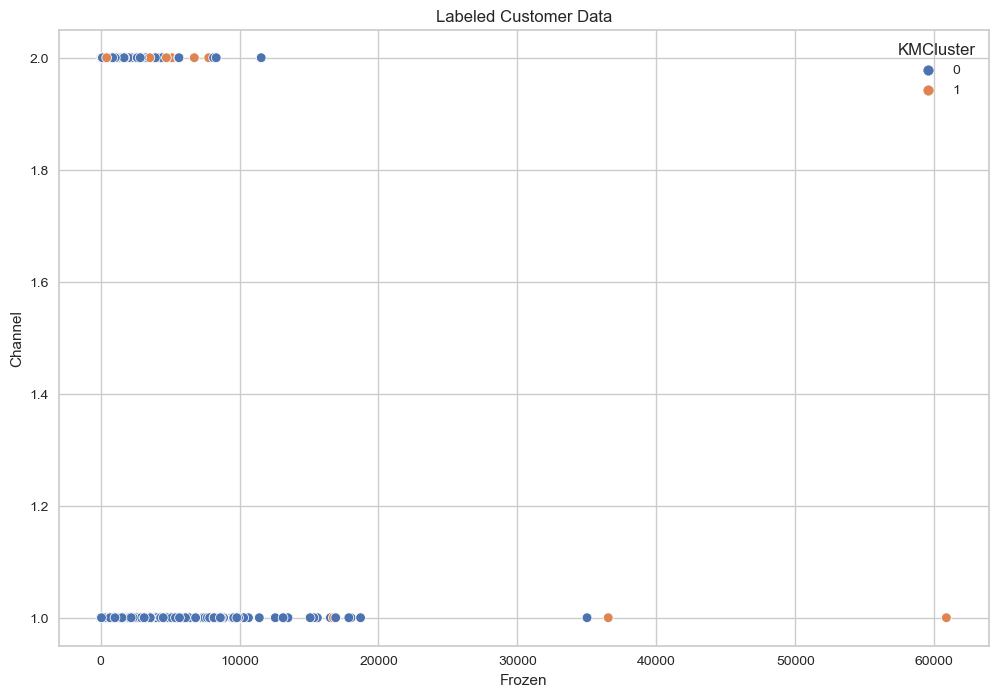

In [75]:
plt.figure(figsize=(12,8))

sns.scatterplot(x='Frozen', 
                y='Channel', 
                data=input_data, 
                hue= "KMCluster",
                palette="deep"
               ).set_title('Labeled Customer Data')

plt.show()

# Elbow method

C:\Users\dchatzopoulou\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\dchatzopoulou\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\dchatzopoulou\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\dchatzopoulou\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known

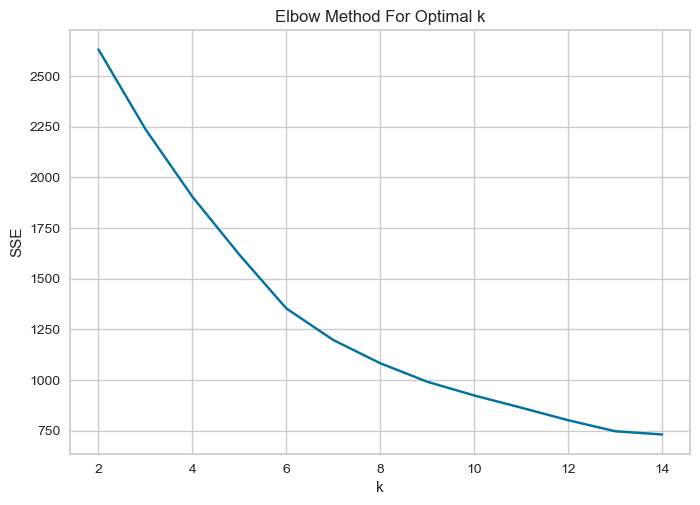

In [76]:
# Create an empty list for sum of squared distances to be appended for k values 2 to 15
Sum_of_squared_distances = [] 

# Values for K (centroids) 
K = range(2, 15)

for k in K:
    km = KMeans(n_clusters =k)
    km = km.fit(X_scaled)
    
    # model.inertia_: Sum of squared distances of samples to their closest cluster center, 
    # weighted by the sample weights if provided 
    # (from documentation - https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

# Silhouette Coefficient

C:\Users\dchatzopoulou\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\dchatzopoulou\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\dchatzopoulou\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\dchatzopoulou\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known

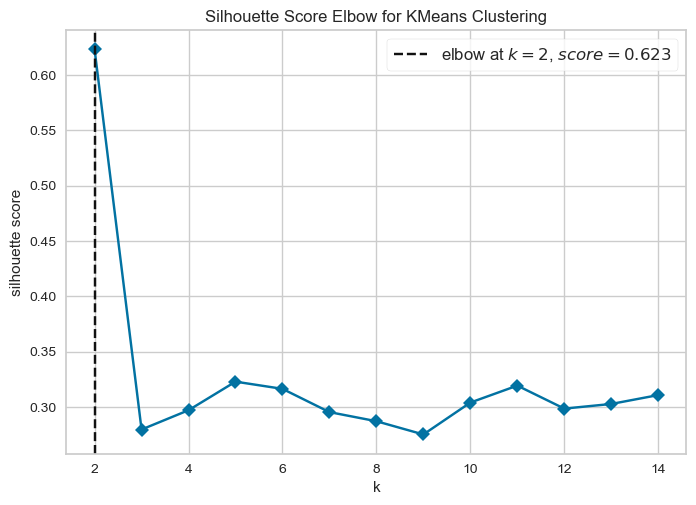

In [77]:
model = KMeans(random_state=123) 

visualizer = KElbowVisualizer(model, k=(2, 15), metric='silhouette', timings=False)
visualizer.fit(X_scaled)    
visualizer.poof()
plt.show();

In [78]:
# After finding the optimal number of clusters, fit the K-Means clustering model to the dataset and then predict clusters for each of the data elements.

In [79]:
opt_k = 2

# Instantiate a KMeans object with the OPTIMAL k as found above 
# Store it in a variable named "kmodel" 
# Fit the kmodel model on the X_scaled data and use the predict() function (or fit_predict() directly) 
# to get the assinged clusters for each point 
# Save the results in a new variable "cluster_assignment"

kmodel = KMeans(n_clusters=opt_k)
cluster_assignment = kmodel.fit_predict(X_scaled)
cluster_assignment

C:\Users\dchatzopoulou\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [80]:
# After we get the cluster of each data, then we add the new column, by naming it as “Cluster”.

In [81]:
# Store the results of cluster_assignment to input_data["KMCluster"]
# Use head() once more on input_data

input_data["KMCluster"] = cluster_assignment
input_data.head(10)

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total,KMCluster
Channel,,,,,,,,,
2,3,12669,9656,7561,214,2674,1338,34112,1
2,3,7057,9810,9568,1762,3293,1776,33266,1
2,3,6353,8808,7684,2405,3516,7844,36610,1
1,3,13265,1196,4221,6404,507,1788,27381,1
2,3,22615,5410,7198,3915,1777,5185,46100,1
2,3,9413,8259,5126,666,1795,1451,26710,1
2,3,12126,3199,6975,480,3140,545,26465,1
2,3,7579,4956,9426,1669,3321,2566,29517,1
1,3,5963,3648,6192,425,1716,750,18694,1


In [82]:
# Get the centroids of each cluster 
kmodel.cluster_centers_

array([[-6.10334623e-03,  4.64275122e-01,  2.79756111e+00,
         2.73477812e+00,  6.75215172e-01,  2.63029061e+00,
         1.34960674e+00,  2.73683177e+00],
       [ 3.83301937e-04, -2.91573748e-02, -1.75692244e-01,
        -1.71749350e-01, -4.24048176e-02, -1.65187333e-01,
        -8.47579109e-02, -1.71878324e-01]])

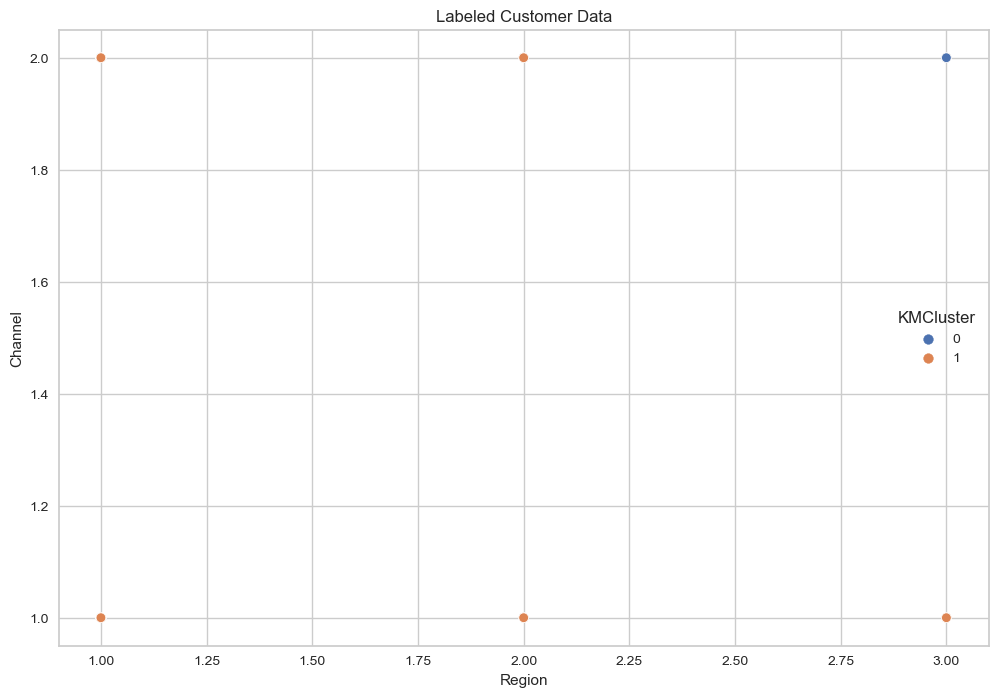

In [83]:
# Visualize the clusters using a scatterplot and set the hue as the "KMCluster"

plt.figure(figsize=(12,8))

sns.scatterplot(x='Region', 
                y='Channel', 
                data=input_data, 
                hue= "KMCluster",
                palette="deep"
               ).set_title('Labeled Customer Data')

plt.show()